**Проект телекоммуникации**

## Описание проекта: телекоммуникации

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг:

Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).
Также доступны такие услуги:

 - Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
 - Выделенная линия технической поддержки (TechSupport);
 - Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
 - Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

 - contract.csv — информация о договоре;
 - personal.csv — персональные данные клиента;
 - internet.csv — информация об интернет-услугах;
 - phone.csv — информация об услугах телефонии.

### Описание полей данных

 - BeginDate – дата начала пользования услугами.
 - EndDate – дата окончания пользования услугами.
 - Type – тип оплаты: ежемесячный, годовой и тд.
 - PaperlessBilling – безналичный расчет.
 - PaymentMethod – способ оплаты.
 - MonthlyCharges – ежемесячные траты на услуги.
 - TotalCharges – всего потрачено денег на услуги.
 - Dependents – наличие иждивенцев.
 - Senior Citizen – наличие пенсионного статуса по возрасту.
 - Partner – наличие супруга(и).
 - MultipleLines – наличие возможности ведения параллельных линий во время звонка.

Во всех файлах столбец customerID содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## План работы

1. Загрузить данные, сделать их предварительный анализ: рассмотреть и проанализировать каждый набор данных, посмотреть взаимосвязи.

2. Провести предобработку данных, объединить данные, подготовить признаки и, при необходимости, добавить новые признаки. Выделить/создать целевой признак. Сделать исследовательский анализ данных (EDA) и выводы по результатам EDA.

3. Разделить итоговый датасет на тренировочную и тестовую выборки. В случае необходимости, провести кодирование и масштабирование.

4. Определить модели, подходящие для исследования (предварительно предполагается использовать Классификаторы LogisticRegression, CatBoost, LightGBM и одну из ассемблинговых моделей), провести подбор гиперпараметров, выделить важные фичи.

5. Сравнить модели по результатам кросс-валидации и оценить эффективность лучшей модели на тестовой выборке.

6. Провести анализ влияния различных факторов лучшей модели.

7. Общий вывод по результатам исследования.

PS: В процессе проведения исследования, план работ может быть скорректирован исходя из полученных результатов, а также в случае появления других дополнительных предпосылок.

In [1]:
!pip install -U catboost

In [2]:
!pip install -U seaborn

In [3]:
!pip install -U scikit-learn

In [4]:
!pip install phik

In [5]:
! pip install shap

In [6]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
import phik
import shap

from time import time
# import tqdm
from tqdm.notebook import tqdm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool, cv
from lightgbm import LGBMClassifier
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split,
    cross_val_score
)

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, make_scorer, roc_curve

RST = 30723

In [7]:
contract = pd.read_csv('/datasets/contract_new.csv', index_col=['customerID'],
                          parse_dates=['BeginDate', 'EndDate'])
personal = pd.read_csv('/datasets/personal_new.csv', index_col='customerID')
internet = pd.read_csv('/datasets/internet_new.csv', index_col='customerID')
phone = pd.read_csv('/datasets/phone_new.csv', index_col='customerID')

## Предварительный анализ данных

### Проанализируем таблицу **сontract**

In [8]:
contract.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [9]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 440.2+ KB


In [10]:
#Проверим на пропуски
contract.isna().sum()

BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [11]:
# Проверим задвоенные значения
contract.index.duplicated().sum()
#contract.duplicated()

0

In [12]:
contract['EndDate'].value_counts()

No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2014-12-01       2
2014-09-01       2
2014-06-01       1
2014-11-01       1
2014-10-01       1
Name: EndDate, Length: 67, dtype: int64

In [13]:
contract['BeginDate'].value_counts().sort_values(ascending = True)

2013-11-01      2
2013-10-01      3
2013-12-01      3
2014-01-01      7
2020-02-01     11
             ... 
2020-01-01    233
2019-11-01    237
2019-09-01    237
2019-10-01    237
2014-02-01    366
Name: BeginDate, Length: 77, dtype: int64

<AxesSubplot:>

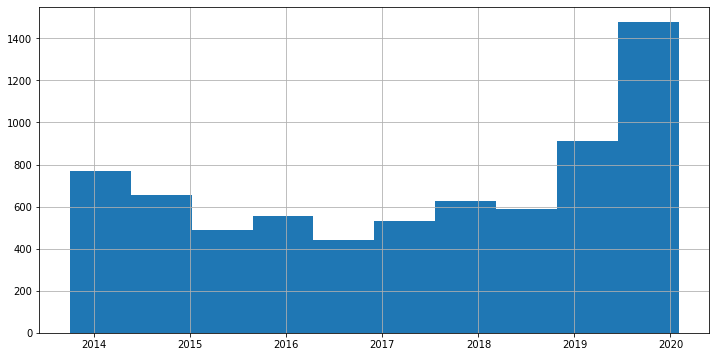

In [14]:
contract['BeginDate'].hist(figsize=(12,6))

<AxesSubplot:>

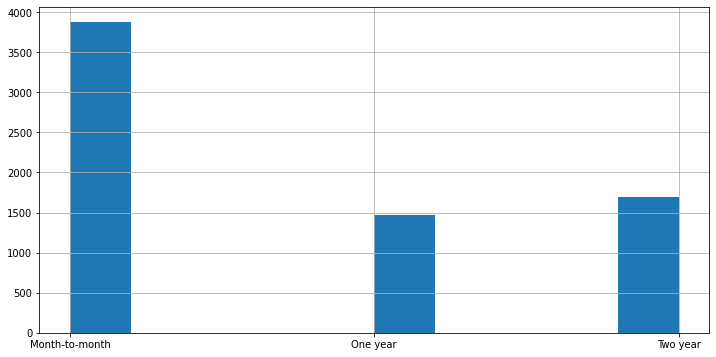

In [15]:
contract['Type'].hist(figsize=(12,6))

<AxesSubplot:>

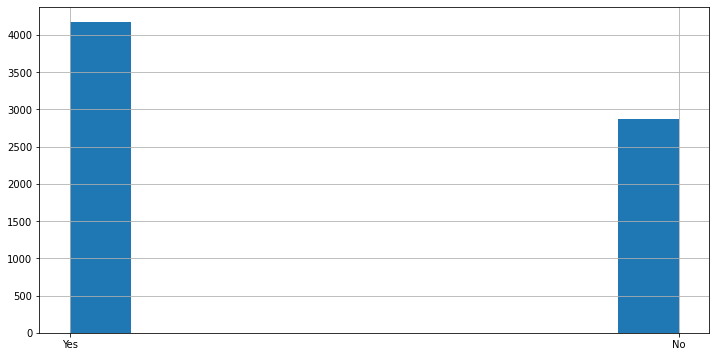

In [16]:
contract['PaperlessBilling'].hist(figsize=(12,6))

<AxesSubplot:>

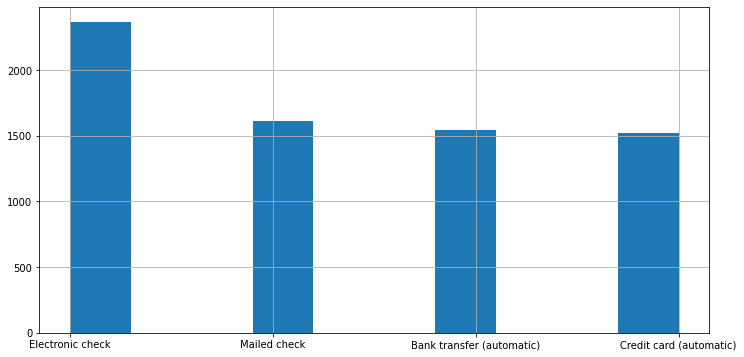

In [17]:
contract['PaymentMethod'].hist(figsize=(12,6))

In [18]:
contract.groupby('Type')['MonthlyCharges'].count()

Type
Month-to-month    3875
One year          1473
Two year          1695
Name: MonthlyCharges, dtype: int64

<AxesSubplot:>

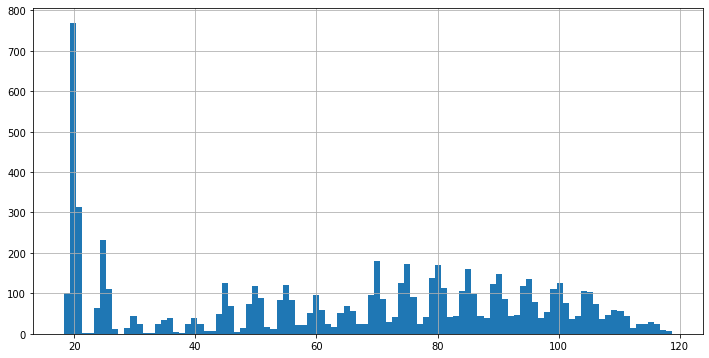

In [19]:
# Построим распределение признака `MonthlyCharges`
contract['MonthlyCharges'].hist(bins=100, figsize=(12,6))

Вывод по таблице **contract**

- данные готовы для анализа, пропусков и дублирующих значений нет.
- необходимо изменить тип данных для признаков BeginDate, EndDate, MonthlyCharges, TotalCharges
- большенство клиентов выбирают платить каждый месяц. При этом, количество клиентов, которые оплачивают сразу на 2 года, больше, чем те, кто  оплачивают год.
- Чаще клиенты выбирают электронную оплату. 
- еобходимо подробнее изучить ежемесячную оплату, изучить выброс в ней и распредение.


### Проанализируем таблицу **personal**

In [20]:
personal.head()

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


In [21]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


In [22]:
# Проверим наличие пропусков
personal.isna().sum()

gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

In [23]:
# Проверим задвоенные значения
personal.index.duplicated().sum()

0

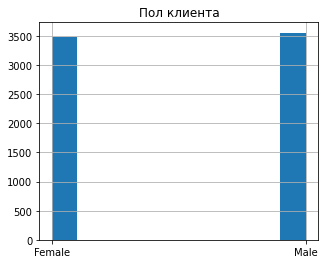

In [24]:
# Распределение 
personal['gender'].hist(figsize=(5,4))
plt.title('Пол клиента');

In [25]:
personal['SeniorCitizen'].value_counts(normalize = True)

0    0.837853
1    0.162147
Name: SeniorCitizen, dtype: float64

In [26]:
personal['Partner'].value_counts(normalize = True)

No     0.516967
Yes    0.483033
Name: Partner, dtype: float64

In [27]:
personal['Dependents'].value_counts(normalize = True)

No     0.700412
Yes    0.299588
Name: Dependents, dtype: float64

Вывод по таблице **personal**
 - данные готовы для анализа, пропусков и дублирующих значений нет.
 - Клиенты распределены почти поровну по половому признаку.
 - Доля стариков значительно меньше, около 16%.
 - Доля женатых клиентов и неженатых клиентов - практически одинакова.
 - Отмечается перевес клиентов,  у которых нет иждивенцев. 

### Проанализируем таблицу **internet**

In [28]:
internet.head()

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


In [29]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


In [30]:
#Проверим на пропуски
internet.isna().sum()

InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [31]:
# Проверим задвоенные значения
internet.index.duplicated().sum()

0

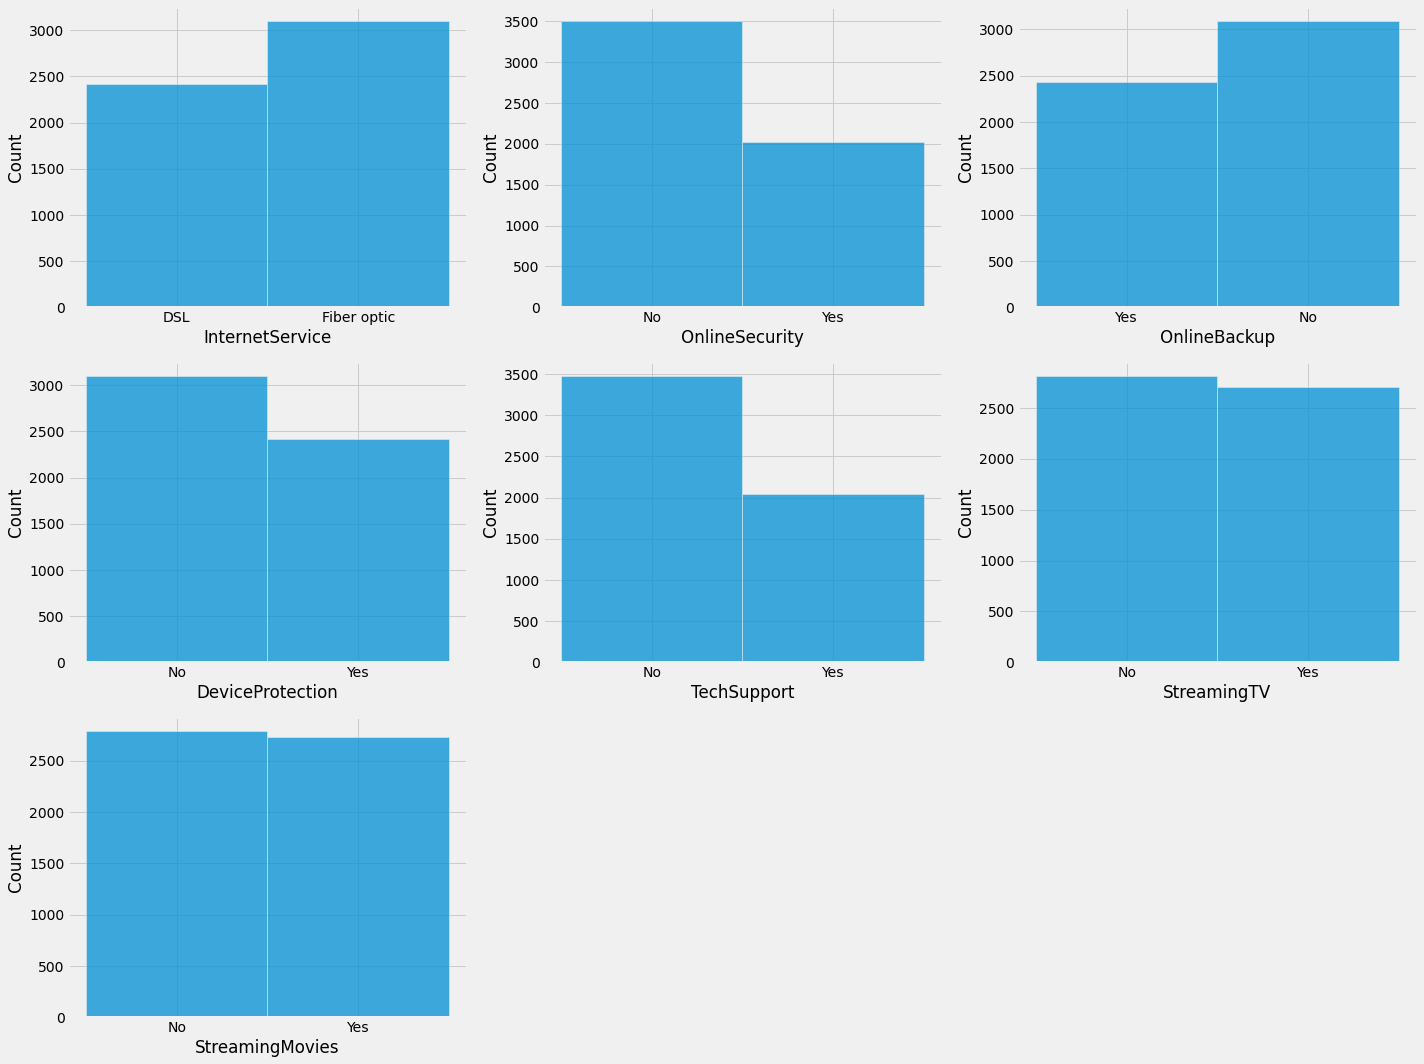

In [32]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=[20,15])
plot_number=1
for i in internet.columns:
    ax=plt.subplot(3,3,plot_number)
    sns.histplot(internet[i])
    plot_number+=1

plt.tight_layout()
plt.show()

In [33]:
print('Тип интернет подключения:')
internet['InternetService'].value_counts(normalize = True)

Тип интернет подключения:


Fiber optic    0.561175
DSL            0.438825
Name: InternetService, dtype: float64

In [34]:
print('OnlineSecurity:')
internet['OnlineSecurity'].value_counts(normalize = True)

OnlineSecurity:


No     0.63404
Yes    0.36596
Name: OnlineSecurity, dtype: float64

In [35]:
print('OnlineBackup:')
internet['OnlineBackup'].value_counts(normalize = True)

OnlineBackup:


No     0.559724
Yes    0.440276
Name: OnlineBackup, dtype: float64

In [36]:
print('TechSupport:' )
internet['TechSupport'].value_counts(normalize = True)

TechSupport:


No     0.629509
Yes    0.370491
Name: TechSupport, dtype: float64

In [37]:
print('DeviceProtection:') 
internet['DeviceProtection'].value_counts(normalize = True)

DeviceProtection:


No     0.560993
Yes    0.439007
Name: DeviceProtection, dtype: float64

In [38]:
print('Стриминговое телевидение')
internet['StreamingTV'].value_counts(normalize = True)

Стриминговое телевидение


No     0.509335
Yes    0.490665
Name: StreamingTV, dtype: float64

In [39]:
print('Каталог фильмов')
internet['StreamingMovies'].value_counts(normalize = True)

Каталог фильмов


No     0.504803
Yes    0.495197
Name: StreamingMovies, dtype: float64

Вывод по таблице **internet**
 - данные готовы для анализа, пропусков и дублирующих значений нет.
 - количество записей меньше, чем в предыдущих таблицах.В этом наборе данных присутсвуют уже не все пользователи, так не все клиенты компнии пользуются доступом в Интернет через этого провайдера.
 - пользователи чаще выбирают оптоволокно
 - услугами безопасности и техподдержкой пользуется меньшая половина позователнй 
 - в стриминговых услугах почти равное распределение пользователей.

### Проанализируем таблицу **phone**

In [40]:
phone.head()

,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


In [41]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


In [42]:
#Проверим на пропуски
phone.isna().sum()

MultipleLines    0
dtype: int64

In [43]:
# Проверим задвоенные значения
phone.index.duplicated().sum()

0

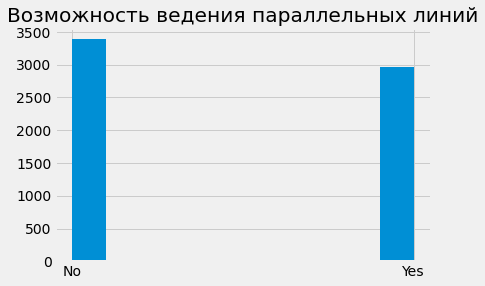

In [44]:
phone['MultipleLines'].hist()
plt.title('Возможность ведения параллельных линий');

Вывод по таблице **phone**

 - данные готовы для анализа, пропусков и дублирующих значений нет.
 - только часть клиентов использует услугу телефонии.
 - у большинства пользователй отсутствует функция ведения параллельных линий

## Предобработка и исследовательский анализ данных (EDA)

### Предобработка данных

Добавим категориальный признак

In [45]:
contract['target'] = (contract['EndDate'] != 'No').astype(int)

Перобразуем тип данных у признаков BeginDate, EndDate, MonthlyCharges, TotalCharges и заменим пропущенные значения

In [46]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])

In [47]:
contract['MonthlyCharges'] = contract['MonthlyCharges'].astype(float)

In [48]:
contract['EndDate'] = contract['EndDate'].replace('No', '2020-02-01')
contract['EndDate'] = pd.to_datetime(contract['EndDate'])

In [49]:
contract.query('TotalCharges ==  " "')

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
customerID,,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,0
3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,0
5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,0
4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,0
1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,0
7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,0
3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,0
2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,0
2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,0


Все пропуски обьясняются банальным отсутствием комисии, т.к. клиенты не пользовались услугами компании 

In [50]:
contract['TotalCharges'] = contract['TotalCharges'].replace(' ', '0')
contract['TotalCharges'] = contract['TotalCharges'].astype(float)

In [51]:
# проверка contract['TotalCharges'].value_counts()

In [52]:
personal['SeniorCitizen'] = personal['SeniorCitizen'].astype(str) # добавил для OHE

Добавление дополнительных признаков

In [53]:
# Количество дней в течение которых клиент  пользовался услугами
contract['period'] = (contract['EndDate'] - contract['BeginDate']).dt.days

In [54]:
#В таблицы internet и phone добавим признаки для информативности при объединении
internet['Internet'] = '1'
phone['Phone'] = '1'

Объединение признаков

In [55]:
# contract = contract.join(personal)
# contract = contract.join(internet)
# contract = contract.join(phone)

contract = pd.merge(contract, personal, left_index=True, right_index=True, how='left' )
contract = pd.merge(contract, internet, left_index=True, right_index=True, how='left' )
contract = pd.merge(contract, phone, left_index=True, right_index=True, how='left' )

In [56]:
df=contract.copy()

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   target            7043 non-null   int64         
 8   period            7043 non-null   int64         
 9   gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   object        
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   5517 non-null   object        
 14  OnlineSecurity

In [58]:
df = df.fillna('No')

In [59]:
# Категориальная переменная на основании вышеуказанной
# contract['q_period'] = pd.qcut(contract['period'], 3)
# contract['q_period']
df['cl_cat'] = pd.qcut(df['period'], 3, labels=['1','2','3'])
df['cl_cat']

customerID
7590-VHVEG    1
5575-GNVDE    2
3668-QPYBK    1
7795-CFOCW    3
9237-HQITU    1
             ..
6840-RESVB    2
2234-XADUH    3
4801-JZAZL    1
8361-LTMKD    1
3186-AJIEK    3
Name: cl_cat, Length: 7043, dtype: category
Categories (3, object): ['1' < '2' < '3']

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   target            7043 non-null   int64         
 8   period            7043 non-null   int64         
 9   gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   object        
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   7043 non-null   object        
 14  OnlineSecurity

In [61]:
df.head(20)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,period,gender,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Internet,MultipleLines,Phone,cl_cat
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,...,No,Yes,No,No,No,No,1,No,No,1
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036,Male,...,Yes,No,Yes,No,No,No,1,No,1,2
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,...,Yes,Yes,No,No,No,No,1,No,1,1
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,...,Yes,No,Yes,Yes,No,No,1,No,No,3
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,...,No,No,No,No,No,No,1,No,1,1
9305-CDSKC,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,99.65,1150.96,0,337,Female,...,No,No,Yes,No,Yes,Yes,1,Yes,1,1
1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,0,671,Male,...,No,Yes,No,No,Yes,No,1,Yes,1,2
6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,300.48,0,306,Female,...,Yes,No,No,No,No,No,1,No,No,1
7892-POOKP,2017-07-01,2020-02-01,Month-to-month,Yes,Electronic check,104.80,3573.68,0,945,Female,...,No,No,Yes,Yes,Yes,Yes,1,Yes,1,2


### Исследовательский анализ данных (EDA). 

In [62]:
df.phik_matrix()

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'target', 'period']


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,period,gender,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Internet,MultipleLines,Phone,cl_cat
BeginDate,1.000000,0.548313,0.766249,0.081447,0.456389,0.421886,0.774207,0.450254,0.978521,0.011268,...,0.403560,0.445583,0.456002,0.399506,0.359784,0.371863,0.132857,0.428109,0.032950,0.975893
EndDate,0.548313,1.000000,0.285429,0.062936,0.169262,0.173493,0.217670,1.000000,0.396342,0.018274,...,0.129611,0.203659,0.197691,0.112812,0.164794,0.177561,0.076694,0.209337,0.000000,0.370636
Type,0.766249,0.285429,1.000000,0.106860,0.277462,0.388444,0.470860,0.094015,0.634155,0.000000,...,0.152145,0.098884,0.137610,0.179999,0.066961,0.069608,0.146647,0.065498,0.000000,0.766672
PaperlessBilling,0.081447,0.062936,0.106860,1.000000,0.370495,0.467812,0.201703,0.083398,0.026799,0.000000,...,0.000000,0.196443,0.160796,0.055929,0.343524,0.325551,0.482393,0.252972,0.016811,0.000000
PaymentMethod,0.456389,0.169262,0.277462,0.370495,1.000000,0.399526,0.335666,0.214832,0.350964,0.000000,...,0.262911,0.282475,0.306866,0.272101,0.377209,0.378907,0.535120,0.339313,0.000000,0.256326
MonthlyCharges,0.421886,0.173493,0.388444,0.467812,0.399526,1.000000,0.710905,0.226280,0.387727,0.008175,...,0.551621,0.629541,0.667481,0.576525,0.835340,0.833307,0.998690,0.675883,0.831362,0.367683
TotalCharges,0.774207,0.217670,0.470860,0.201703,0.335666,0.710905,1.000000,0.302890,0.848337,0.000000,...,0.522090,0.622445,0.640977,0.550065,0.641488,0.643210,0.548907,0.573191,0.160505,0.795607
target,0.450254,1.000000,0.094015,0.083398,0.214832,0.226280,0.302890,1.000000,0.374569,0.008581,...,0.132594,0.229482,0.218380,0.103652,0.200198,0.222232,0.114593,0.261237,0.000000,0.121156
period,0.978521,0.396342,0.634155,0.026799,0.350964,0.387727,0.848337,0.374569,1.000000,0.000000,...,0.395693,0.414982,0.426931,0.404795,0.339313,0.339313,0.040534,0.398222,0.006730,0.956190
gender,0.011268,0.018274,0.000000,0.000000,0.000000,0.008175,0.000000,0.008581,0.000000,1.000000,...,0.018397,0.009882,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Наблюдается мультиколлениарность между рядом признаков: target, EndDate,  period  и BeginDate. Это весьма логично, т.к. признаки  target и period  строились на основании BeginDate и EndDate. Чтобы избежать проблемы переобучения, при подготовке датасета для машинного обучения, BeginDate и EndDate необходимо будет удалить.

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'target', 'period']


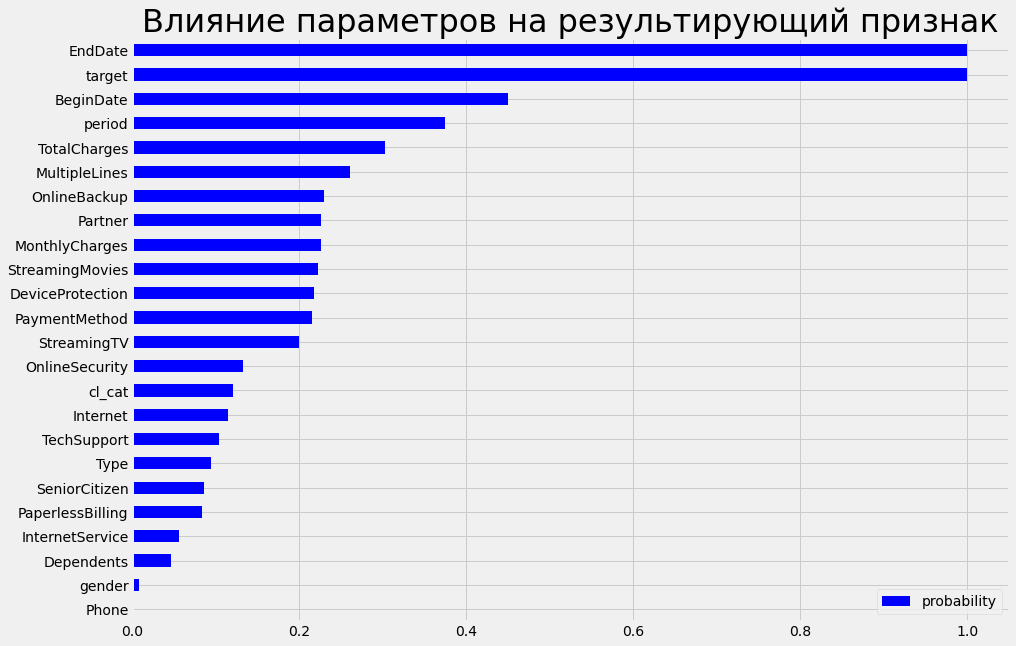

In [63]:
ph_t = df.phik_matrix()
ph_t.iloc[:, 7].sort_values(ascending=True).plot.barh(figsize = (14,10), label='probability', color='b', legend=True)
plt.title('Влияние параметров на результирующий признак', fontsize=32)
plt.show()

In [64]:
phik_overview = df.phik_matrix()
phik_overview['target'].sort_values(ascending=False)

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'target', 'period']


target              1.000000
EndDate             1.000000
BeginDate           0.450254
period              0.374569
TotalCharges        0.302890
MultipleLines       0.261237
OnlineBackup        0.229482
Partner             0.226688
MonthlyCharges      0.226280
StreamingMovies     0.222232
DeviceProtection    0.218380
PaymentMethod       0.214832
StreamingTV         0.200198
OnlineSecurity      0.132594
cl_cat              0.121156
Internet            0.114593
TechSupport         0.103652
Type                0.094015
SeniorCitizen       0.086159
PaperlessBilling    0.083398
InternetService     0.056621
Dependents          0.046871
gender              0.008581
Phone               0.000000
Name: target, dtype: float64

Вышеукзанный график показывает "вклад" каждого признака в общий результат. 

Распределение целевого признака

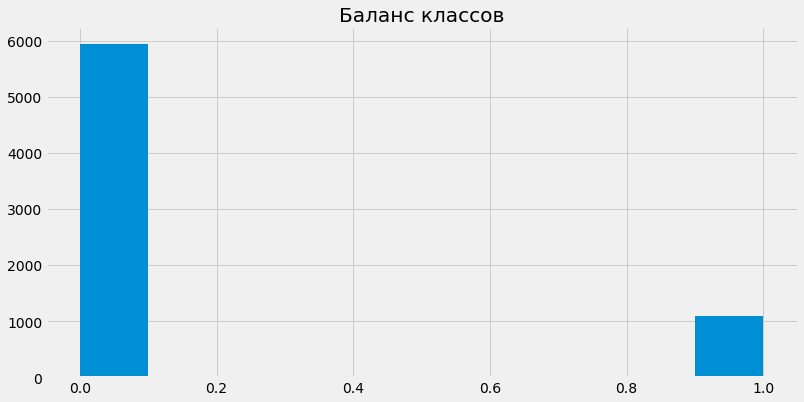

In [65]:
df['target'].hist(figsize=(12,6))
plt.title('Баланс классов');

In [66]:
df['target'].value_counts()

0    5942
1    1101
Name: target, dtype: int64

In [67]:
df['target'].value_counts(normalize = True)

0    0.843675
1    0.156325
Name: target, dtype: float64

Наблюдается существенный дисбаланс целевого признака. Только 15,6 % клиентов отвергли сервис заказчика.

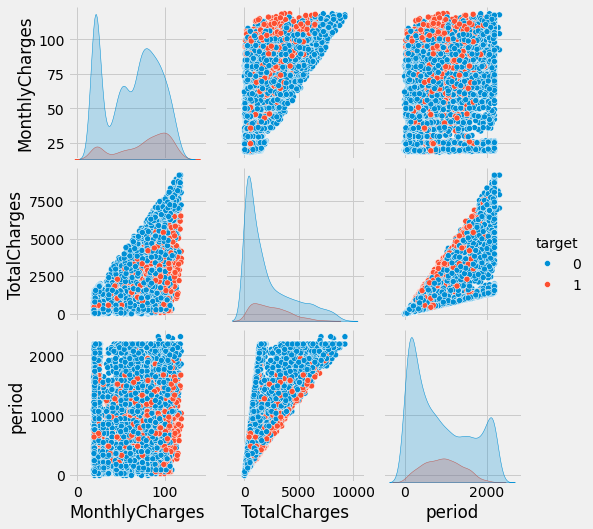

In [68]:
sns.pairplot(df, hue = 'target')

На графике видно что плоность ушедших клиентов больше у дорогих клиентов, у которых ежемесечный платеж выше. Необходимо разобрать отдельно. С точки зрения общих платежей, очень ушедших клиентов, кто обеспечил существенную выручку компании. 

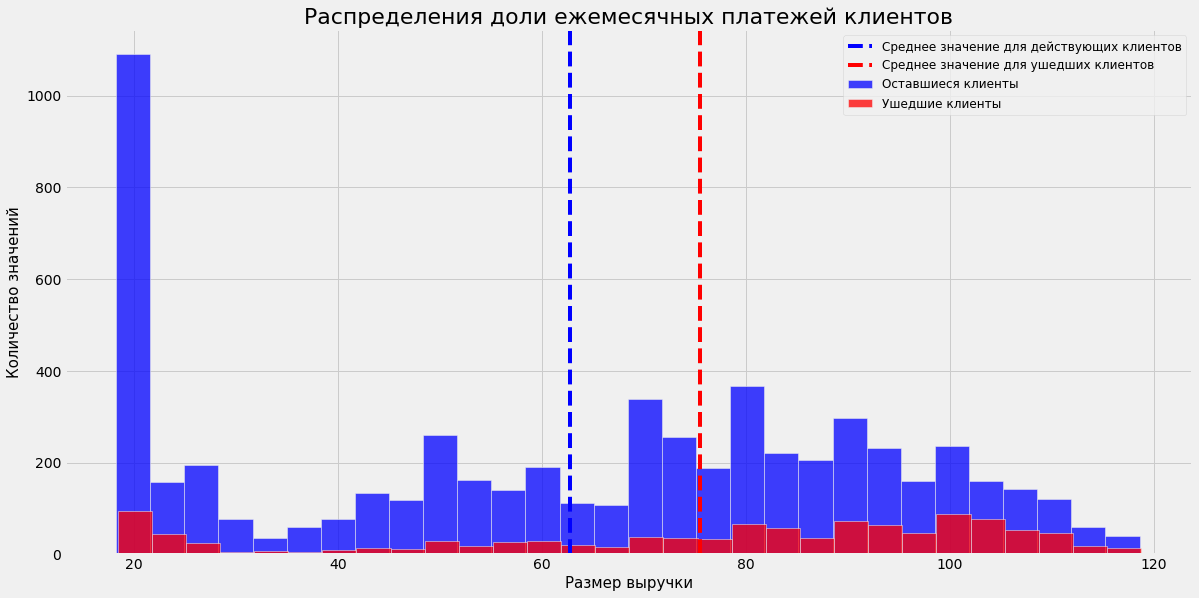

In [69]:
f, axes = plt.subplots(1, 1, figsize=(18, 9))
axes.set_title('Распределения доли ежемесячных платежей клиентов', fontsize=22)
axes.set_ylabel('Количество значений', fontsize=15)
sns.histplot(df[df['target'] == 0]['MonthlyCharges'], bins=30, color = 'b')
sns.histplot(df[df['target'] == 1]['MonthlyCharges'], bins = 30, color = 'r')
axes.set_xlabel('Размер выручки', fontsize=15)
plt.axvline(df[df['target']  == 0]['MonthlyCharges'].mean(), 0, color = 'b', linestyle='--', linewidth = 4)
plt.axvline(df[df['target']  == 1]['MonthlyCharges'].mean(), 0, color = 'r', linestyle='--', linewidth = 4)
axes.legend(labels=["Среднее значение для действующих клиентов","Среднее значение для ушедших клиентов", 
                    "Оставшиеся клиенты","Ушедшие клиенты"], fontsize=12);

Из графика видно, что уходят клиенты с большим среднемесячным платежом

**Вывод по результатам EDA.**

 - Был проведен исследовательский анализ данных.
 - Выявлен дизбаланс классов результирующего признака.
 - Показано,  что в основном ушедшие клиенты были те, у которых ежемесечный платеж был от 70 до 110.
 - Также наблюдается нулевая корреляция между результирующим признаком и использованием услуг телефони, т.е. аказчик в первую очередь выступает, телефонным оператором, а уже потом как интернет провайдер.
 - Используя пакет Phik, рассмотрели какие параметры оказывают наибольшее влияние на конечный резульат.
 -  Была выявлена мультиколлениарность между рядом признаков: target, EndDate, period и BeginDate. Это весьма логично, т.к. мы построили признаки target и period на основании BeginDate и EndDate. Чтобы избежать проблемы переобучения, при подготовке датасета для машинного обучения, BeginDate и EndDate необходимо будет удалить.
 


##  Разделение датасета на тренировочную и тестовую выборки. Кодирование и масштабирование

In [70]:
df.columns#.to_list()
df.dtypes

BeginDate           datetime64[ns]
EndDate             datetime64[ns]
Type                        object
PaperlessBilling            object
PaymentMethod               object
MonthlyCharges             float64
TotalCharges               float64
target                       int64
period                       int64
gender                      object
SeniorCitizen               object
Partner                     object
Dependents                  object
InternetService             object
OnlineSecurity              object
OnlineBackup                object
DeviceProtection            object
TechSupport                 object
StreamingTV                 object
StreamingMovies             object
Internet                    object
MultipleLines               object
Phone                       object
cl_cat                    category
dtype: object

In [71]:
#Удаляем лишние ячейки
data = df.drop(['EndDate', 'BeginDate'], axis=1,  errors='ignore') #inplace= True,
data.columns

Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'target', 'period', 'gender', 'SeniorCitizen',
       'Partner', 'Dependents', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Internet', 'MultipleLines', 'Phone', 'cl_cat'],
      dtype='object')

In [72]:
# features = df.drop('target', axis=1)
# target = df['target']
X=[col for col in data.columns if col != 'target']
y=['target']
X

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'period',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Internet',
 'MultipleLines',
 'Phone',
 'cl_cat']

In [73]:
numeric_features = ['MonthlyCharges', 'TotalCharges', 'period']

In [74]:
cat_features = [col for col in data.columns if (col not in numeric_features) and  (col != 'target')]
cat_features

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Internet',
 'MultipleLines',
 'Phone',
 'cl_cat']

In [75]:
X_train, X_test, y_train, y_test, = train_test_split(data[X], data[y], test_size=0.25, stratify=data[y], random_state=RST)        

In [76]:
print(f"Количество строк в X_train по классам: {X_train.shape[0]}")
print(f"Количество строк в X_test по классам: {X_test.shape[0]}")

print(f"Количество строк в y_train по классам: {y_train.shape[0]}")
print(f"Количество строк в y_test по классам: {y_test.shape[0]}")


print(f"Пропорция по X: {X_test.shape[0]/X_train.shape[0]}")
print(f"Пропорция по y: {y_test.shape[0]/y_train.shape[0]}")

Количество строк в X_train по классам: 5282
Количество строк в X_test по классам: 1761
Количество строк в y_train по классам: 5282
Количество строк в y_test по классам: 1761
Пропорция по X: 0.33339644074214314
Пропорция по y: 0.33339644074214314


In [77]:
train = pd.merge(X_train, y_train, left_index=True, right_index=True, how='left' )
test = pd.merge(X_test, y_test, left_index=True, right_index=True, how='left' )

In [78]:
print(f"Количество строк в train по классам: {train.shape}")
print(f"Количество строк в test по классам: {test.shape}")

Количество строк в train по классам: (5282, 22)
Количество строк в test по классам: (1761, 22)


Создадим два набора данных. Один оставим без преобразования (для использования в PipeLine и для бустинговых моделей), а второй стандартизируеи и закодируем.

In [79]:
X_train_st = X_train.copy()
X_test_st = X_test.copy()
y_train_st = y_train.copy()
y_test_st = y_test.copy()

Кодируем признаки методом OHE

In [80]:
X_train_st[cat_features].dtypes

Type                  object
PaperlessBilling      object
PaymentMethod         object
gender                object
SeniorCitizen         object
Partner               object
Dependents            object
InternetService       object
OnlineSecurity        object
OnlineBackup          object
DeviceProtection      object
TechSupport           object
StreamingTV           object
StreamingMovies       object
Internet              object
MultipleLines         object
Phone                 object
cl_cat              category
dtype: object

In [81]:
X_train_st['MultipleLines'].value_counts()

No     3043
Yes    2239
Name: MultipleLines, dtype: int64

In [82]:
ohe_features = cat_features #['MonthlyCharges', 'TotalCharges', 'period']

In [83]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='error', sparse=False)

In [84]:
encoder_ohe.fit(X_train_st[ohe_features])

OneHotEncoder(drop='first', sparse=False, sparse_output=False)

In [85]:
X_train_st[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(X_train_st[ohe_features])

In [86]:
X_train_st = X_train_st.drop(ohe_features, axis=1)

In [87]:
X_test_st[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(X_test_st[ohe_features])

In [88]:
X_test_st = X_test_st.drop(ohe_features, axis=1)

In [89]:
X_train_st.head()

,MonthlyCharges,TotalCharges,period,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,...,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Internet_No,MultipleLines_Yes,Phone_No,cl_cat_2,cl_cat_3
customerID,,,,,,,,,,,,,,,,,,,,,
8199-ZLLSA,118.35,3419.13,823,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
4115-UMJFQ,35.75,2466.75,2102,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3506-OVLKD,26.20,926.17,1067,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
6972-SNKKW,20.00,120.00,184,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5862-BRIXZ,60.75,2794.50,1401,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0


Cтандартизируем признаки 

In [90]:
scaler = StandardScaler()
scaler.fit(X_train_st[numeric_features])
X_train_st[numeric_features] = scaler.transform(X_train_st[numeric_features])
X_test_st[numeric_features]  = scaler.transform(X_test_st[numeric_features])

## Моделирование

In [91]:
%%time
# Логистическая регрессия
#  https://stackoverflow.com/questions/39163354/evaluating-logistic-regression-with-cross-validation
model_log = LogisticRegression(solver = 'liblinear', random_state=RST, class_weight='balanced')
roc_auc_log = cross_val_score(model_log, X_train_st, y_train_st, cv=4,scoring='roc_auc').mean()
print (roc_auc_log)

0.7939185892113177
CPU times: user 374 ms, sys: 390 ms, total: 764 ms
Wall time: 733 ms


In [92]:
%%time
# Случайный лес

model_rf = RandomForestClassifier(random_state=RST)

param_grid_rf = {
    'n_estimators': range(50, 251, 50),
    'max_depth': range(2, 15),
    'min_samples_split': (2, 3, 4),
    'min_samples_leaf': (1, 2, 3, 4)
}
model_rf.fit(X_train_st, y_train_st) 

CPU times: user 666 ms, sys: 2.92 ms, total: 668 ms
Wall time: 756 ms


RandomForestClassifier(random_state=30723)

In [93]:
%%time
rf_grid = RandomizedSearchCV(model_rf,  param_grid_rf, scoring='roc_auc', cv=4)
rf_grid.fit(X_train_st, y_train_st)

CPU times: user 22.7 s, sys: 126 ms, total: 22.8 s
Wall time: 23.1 s


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(random_state=30723),
                   param_distributions={'max_depth': range(2, 15),
                                        'min_samples_leaf': (1, 2, 3, 4),
                                        'min_samples_split': (2, 3, 4),
                                        'n_estimators': range(50, 251, 50)},
                   scoring='roc_auc')

In [94]:
rf_grid.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_depth': 11}

In [95]:
roc_auc_rf = rf_grid.best_score_
roc_auc_rf

0.8197294700515679

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


**CatBoost**

**CatBoost grid_search**

https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier_grid_search

In [96]:
# # grid = {'learning_rate': [0.01, 0.05, 0,1],
#         'depth': [4, 6],
#         'l2_leaf_reg': [1, 3, 5]}

grid = {'learning_rate': [0.03, 0.1]}

params = {'cat_features': cat_features,
              'loss_function': 'Logloss',
               'eval_metric': 'AUC:hints=skip_train~false',
              'random_state': RST,
              'iterations' :1000, 
              'early_stopping_rounds': 200,
              'verbose':200}

cat_model = CatBoostClassifier(**params)

cv_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features, has_header=True)    
cat_gs = cat_model.grid_search(grid,  cv_dataset, cv=3, stratified=None)


0:	learn: 0.7480542	test: 0.7353854	best: 0.7353854 (0)	total: 60ms	remaining: 60s
200:	learn: 0.8767688	test: 0.8522912	best: 0.8525305 (199)	total: 1.62s	remaining: 6.45s
400:	learn: 0.9212683	test: 0.8731255	best: 0.8731255 (400)	total: 3.32s	remaining: 4.96s
600:	learn: 0.9573769	test: 0.8991478	best: 0.8991478 (600)	total: 5.24s	remaining: 3.48s
800:	learn: 0.9736910	test: 0.9110712	best: 0.9110712 (800)	total: 7.12s	remaining: 1.77s
999:	learn: 0.9821533	test: 0.9166031	best: 0.9166031 (999)	total: 9.06s	remaining: 0us

bestTest = 0.9166031248
bestIteration = 999

0:	loss: 0.9166031	best: 0.9166031 (0)	total: 9.64s	remaining: 9.64s
0:	learn: 0.7480542	test: 0.7353854	best: 0.7353854 (0)	total: 11.2ms	remaining: 11.2s
200:	learn: 0.9641484	test: 0.9128953	best: 0.9128953 (200)	total: 1.82s	remaining: 7.24s
400:	learn: 0.9905031	test: 0.9230844	best: 0.9231741 (348)	total: 3.78s	remaining: 5.64s
600:	learn: 0.9977983	test: 0.9287508	best: 0.9287508 (600)	total: 5.73s	remaining: 3.8

In [97]:
# cat_model.get_feature_importance(prettified=True)

In [98]:
cat_gs.keys()

dict_keys(['params', 'cv_results'])

In [99]:
cat_gs['params']

{'learning_rate': 0.1}

In [100]:
cv_data= pd.DataFrame(cat_gs['cv_results'])#['test-AUC-mean'].max()

In [101]:
cv_data[cv_data['test-AUC-mean'] == cv_data['test-AUC-mean'].max()]['test-AUC-mean'].values[0]


0.8947941609627348

In [102]:
n_iters1 = cv_data[cv_data['test-AUC-mean'] == cv_data['test-AUC-mean'].max()]['iterations'].values[0]
n_iters1

985

In [103]:
# cat_model.get_params()

# for key,value in cat_model.get_all_params().items():
#     print('{}, {}'.format(key,value))

**CatBoost cv**

https://catboost.ai/en/docs/concepts/python-reference_cv#usage-examples

In [104]:
params = {'cat_features': cat_features,
              'loss_function': 'Logloss',
               'eval_metric': 'AUC:hints=skip_train~false',
              'random_seed': RST,
              'iterations' :1000, 
              'early_stopping_rounds': 200,
              'learning_rate': 0.1,
               'verbose':200}
cv_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features, has_header=True)    
cat_cv = cv(cv_dataset, params, fold_count=3, plot = "True")


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]
0:	learn: 0.7303388	test: 0.6977222	best: 0.6977222 (0)	total: 9.92ms	remaining: 9.91s
200:	learn: 0.9618555	test: 0.8547933	best: 0.8547933 (200)	total: 1.64s	remaining: 6.54s
400:	learn: 0.9924163	test: 0.8720498	best: 0.8731494 (388)	total: 3.45s	remaining: 5.15s
600:	learn: 0.9988179	test: 0.8772822	best: 0.8775455 (576)	total: 5.31s	remaining: 3.53s
800:	learn: 0.9997692	test: 0.8838678	best: 0.8846675 (775)	total: 7.06s	remaining: 1.75s
999:	learn: 0.9999676	test: 0.8856331	best: 0.8857769 (998)	total: 8.92s	remaining: 0us

bestTest = 0.885776913
bestIteration = 998

Training on fold [1/3]
0:	learn: 0.7315328	test: 0.7163440	best: 0.7163440 (0)	total: 10.2ms	remaining: 10.2s
200:	learn: 0.9606535	test: 0.8581843	best: 0.8584414 (198)	total: 1.75s	remaining: 6.94s
400:	learn: 0.9920306	test: 0.8879657	best: 0.8881518 (397)	total: 3.63s	remaining: 5.42s
600:	learn: 0.9981857	test: 0.8951013	best: 0.8952629 (597)	total: 5.5s	remaining: 3.65s
800:	learn: 0.9995

In [105]:
cat_cv

,iterations,test-AUC-mean,test-AUC-std,train-AUC-mean,train-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.715031,0.016690,0.726322,0.008013,0.619952,0.001319,0.619291,0.002066
1,1,0.749830,0.011728,0.765948,0.025409,0.561543,0.004827,0.559993,0.006238
2,2,0.787431,0.020516,0.802379,0.015151,0.513340,0.004266,0.510942,0.005733
3,3,0.794225,0.021219,0.812787,0.006645,0.481278,0.004839,0.478246,0.004135
4,4,0.802412,0.015300,0.821920,0.006664,0.456377,0.009165,0.452719,0.008481
...,...,...,...,...,...,...,...,...,...
995,995,0.894640,0.007947,0.999932,0.000032,0.269306,0.008522,0.050655,0.001993
996,996,0.894716,0.007867,0.999931,0.000030,0.269236,0.008404,0.050582,0.002024
997,997,0.894645,0.007916,0.999932,0.000031,0.269348,0.008518,0.050524,0.002048
998,998,0.894756,0.007808,0.999931,0.000031,0.269243,0.008367,0.050456,0.002082


In [106]:
n_iters2 = cat_cv[cat_cv['test-AUC-mean'] == cat_cv['test-AUC-mean'].max()]['iterations'].values[0]
n_iters2 

985

In [107]:
cat_cv['test-AUC-mean'].max()

0.8947941609627348


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Catboost GridSearchCV (sklearn)**

https://stackoverflow.com/questions/37689942/grid-search-finding-parameters-for-auc

In [108]:
# # grid = {'learning_rate': [0.01, 0.05, 0,1],
#         'depth': [4, 6],
#         'l2_leaf_reg': [1, 3, 5]}

grid1 = {'learning_rate': [0.03, 0.1]}

params1 = {'cat_features': cat_features,
              'loss_function': 'Logloss',
               'eval_metric': 'AUC:hints=skip_train~false',
              'random_state': RST,
              'iterations' :1000, 
              'early_stopping_rounds': 200,
              'verbose':200}

cat_model1 = CatBoostClassifier(**params)

In [109]:
#  cv = StratifiedShuffleSplit(n_splits=5,test_size=0.3,random_state = 0)
# sgkf = StratifiedGroupKFold(n_splits=3)
# StratifiedKFold(n_splits=2, random_state=None, shuffle=False)

cat_gscv = GridSearchCV(cat_model1, grid1, cv=3, scoring='roc_auc', n_jobs=-1)

model_cat_gscv= cat_gscv.fit(X_train, y_train)

0:	learn: 0.6667712	total: 5.95ms	remaining: 5.94s
200:	learn: 0.8873400	total: 1.39s	remaining: 5.52s
400:	learn: 0.9323032	total: 2.84s	remaining: 4.24s
600:	learn: 0.9620624	total: 4.41s	remaining: 2.92s
800:	learn: 0.9784676	total: 5.97s	remaining: 1.48s
999:	learn: 0.9876112	total: 7.48s	remaining: 0us
0:	learn: 0.6525497	total: 5.85ms	remaining: 5.84s
200:	learn: 0.8770809	total: 1.31s	remaining: 5.21s
400:	learn: 0.9193044	total: 2.79s	remaining: 4.17s
600:	learn: 0.9530538	total: 4.37s	remaining: 2.9s
800:	learn: 0.9730481	total: 5.92s	remaining: 1.47s
999:	learn: 0.9830855	total: 7.63s	remaining: 0us
0:	learn: 0.7632083	total: 8.87ms	remaining: 8.86s
200:	learn: 0.8806597	total: 1.29s	remaining: 5.14s
400:	learn: 0.9162891	total: 2.71s	remaining: 4.04s
600:	learn: 0.9493049	total: 4.23s	remaining: 2.81s
800:	learn: 0.9702796	total: 5.72s	remaining: 1.42s
999:	learn: 0.9818719	total: 7.27s	remaining: 0us
0:	learn: 0.6667712	total: 5.74ms	remaining: 5.74s
200:	learn: 0.9691025	t

In [110]:
cat_gscv

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f9f8e6c2610>,
             n_jobs=-1, param_grid={'learning_rate': [0.03, 0.1]},
             scoring='roc_auc')

In [111]:
cat_gscv.best_score_

0.8993229052276889

In [112]:
model_cat_gscv.score

<bound method BaseSearchCV.score of GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f9f8e6c2610>,
             n_jobs=-1, param_grid={'learning_rate': [0.03, 0.1]},
             scoring='roc_auc')>

In [113]:
cat_gscv.best_estimator_

In [114]:
cat_gscv.best_params_

{'learning_rate': 0.1}

In [115]:
cat_model1.get_params()

{'iterations': 1000,
 'learning_rate': 0.1,
 'loss_function': 'Logloss',
 'random_seed': 30723,
 'verbose': 200,
 'eval_metric': 'AUC:hints=skip_train~false',
 'early_stopping_rounds': 200,
 'cat_features': ['Type',
  'PaperlessBilling',
  'PaymentMethod',
  'gender',
  'SeniorCitizen',
  'Partner',
  'Dependents',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Internet',
  'MultipleLines',
  'Phone',
  'cl_cat']}

In [116]:
cat_gscv.cv_results_

{'mean_fit_time': array([9.02932127, 9.35677385]),
 'std_fit_time': array([0.21818571, 0.1879842 ]),
 'mean_score_time': array([0.02322626, 0.02027067]),
 'std_score_time': array([0.00564783, 0.00037108]),
 'param_learning_rate': masked_array(data=[0.03, 0.1],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'learning_rate': 0.03}, {'learning_rate': 0.1}],
 'split0_test_score': array([0.86946274, 0.88245498]),
 'split1_test_score': array([0.89659611, 0.91483666]),
 'split2_test_score': array([0.88349679, 0.90067707]),
 'mean_test_score': array([0.88318521, 0.89932291]),
 'std_test_score': array([0.01107934, 0.0132544 ]),
 'rank_test_score': array([2, 1], dtype=int32)}

**cross_val_score**

In [117]:
cv_roc_cat= cross_val_score(model_cat_gscv, X_train, y_train, cv=3,  verbose=20, n_jobs=-1)

[CV] START .....................................................................
0:	learn: 0.7002390	total: 7.19ms	remaining: 7.18s
200:	learn: 0.8962535	total: 1.05s	remaining: 4.17s
400:	learn: 0.9497894	total: 2.23s	remaining: 3.34s
600:	learn: 0.9769187	total: 3.48s	remaining: 2.31s
800:	learn: 0.9903468	total: 4.81s	remaining: 1.19s
999:	learn: 0.9962582	total: 6.09s	remaining: 0us
0:	learn: 0.7551379	total: 6.75ms	remaining: 6.75s
200:	learn: 0.8923403	total: 1.09s	remaining: 4.35s
400:	learn: 0.9380866	total: 2.34s	remaining: 3.49s
600:	learn: 0.9669281	total: 3.63s	remaining: 2.41s
800:	learn: 0.9825104	total: 4.87s	remaining: 1.21s
999:	learn: 0.9902361	total: 6.18s	remaining: 0us
0:	learn: 0.7765482	total: 7.38ms	remaining: 7.37s
200:	learn: 0.9022897	total: 1.09s	remaining: 4.33s
400:	learn: 0.9473623	total: 2.29s	remaining: 3.43s
600:	learn: 0.9734219	total: 3.55s	remaining: 2.35s
800:	learn: 0.9865012	total: 4.81s	remaining: 1.2s
999:	learn: 0.9941378	total: 6.05s	remainin

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   55.6s


0:	learn: 0.7085060	total: 6.9ms	remaining: 6.89s
200:	learn: 0.8911045	total: 1.05s	remaining: 4.17s
400:	learn: 0.9406504	total: 2.25s	remaining: 3.36s
600:	learn: 0.9705873	total: 3.54s	remaining: 2.35s
800:	learn: 0.9854719	total: 4.8s	remaining: 1.19s
999:	learn: 0.9927366	total: 6.03s	remaining: 0us
0:	learn: 0.6821602	total: 6.94ms	remaining: 6.93s
200:	learn: 0.8939518	total: 1.11s	remaining: 4.41s
400:	learn: 0.9412972	total: 2.31s	remaining: 3.45s
600:	learn: 0.9707373	total: 3.54s	remaining: 2.35s
800:	learn: 0.9835976	total: 4.78s	remaining: 1.19s
999:	learn: 0.9924986	total: 6.07s	remaining: 0us
0:	learn: 0.7352678	total: 6.98ms	remaining: 6.97s
200:	learn: 0.8919672	total: 1.04s	remaining: 4.14s
400:	learn: 0.9362882	total: 2.22s	remaining: 3.31s
600:	learn: 0.9701581	total: 3.5s	remaining: 2.32s
800:	learn: 0.9848965	total: 4.74s	remaining: 1.18s
999:	learn: 0.9922609	total: 5.96s	remaining: 0us
0:	learn: 0.7085060	total: 7.03ms	remaining: 7.02s
200:	learn: 0.9783792	tot

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.8min


0:	learn: 0.7519384	total: 8.1ms	remaining: 8.09s
200:	learn: 0.8933685	total: 1.07s	remaining: 4.26s
400:	learn: 0.9390614	total: 2.24s	remaining: 3.34s
600:	learn: 0.9705032	total: 3.52s	remaining: 2.34s
800:	learn: 0.9853045	total: 4.75s	remaining: 1.18s
999:	learn: 0.9927265	total: 6.01s	remaining: 0us
0:	learn: 0.7614703	total: 6.87ms	remaining: 6.86s
200:	learn: 0.8935184	total: 1.07s	remaining: 4.25s
400:	learn: 0.9384988	total: 2.2s	remaining: 3.29s
600:	learn: 0.9679200	total: 3.41s	remaining: 2.26s
800:	learn: 0.9819319	total: 4.65s	remaining: 1.15s
999:	learn: 0.9893181	total: 5.86s	remaining: 0us
0:	learn: 0.7703098	total: 7.91ms	remaining: 7.9s
200:	learn: 0.8871418	total: 1.02s	remaining: 4.07s
400:	learn: 0.9339399	total: 2.21s	remaining: 3.3s
600:	learn: 0.9641949	total: 3.48s	remaining: 2.31s
800:	learn: 0.9822587	total: 4.81s	remaining: 1.19s
999:	learn: 0.9900362	total: 6.06s	remaining: 0us
0:	learn: 0.7519384	total: 7.05ms	remaining: 7.04s
200:	learn: 0.9756667	tota

[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  2.8min


In [118]:
cv_roc_cat

array([0.88245498, 0.91483666, 0.90067707])

In [119]:
roc_auc_cat= cv_roc_cat.mean()
print('ROC_AUC Catboost:', roc_auc_cat)


ROC_AUC Catboost: 0.8993229052276889


______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

**LightGBM**

In [120]:
%%time
#LightGBM
import lightgbm
lgbm_train_data = lightgbm.Dataset(X_train, label=y_train, )

X_train[cat_features].astype('category')

LightGBM_model = LGBMClassifier()
hyperparams = [{'max_depth' : [1], # -1, 1
                'learning_rate':[0.3], 
                'n_estimators' : [100],  # 200
                'random_state':RST}]


lgcv = GridSearchCV(LightGBM_model, hyperparams, scoring='roc_auc',cv=3)
LightGBM_model.fit(X_train_st, y_train_st)

CPU times: user 416 ms, sys: 14.8 ms, total: 431 ms
Wall time: 385 ms


LGBMClassifier()

In [121]:
cv_roc_lgbm = cross_val_score(LightGBM_model, X_train_st, y_train_st, cv=4, verbose=20)

[CV] START .....................................................................
[CV] END ................................ score: (test=0.871) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.5s


[CV] END ................................ score: (test=0.887) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.9s


[CV] END ................................ score: (test=0.874) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    1.3s


[CV] END ................................ score: (test=0.884) total time=   0.5s


[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    1.8s


In [122]:
roc_auc_lg= cv_roc_lgbm.mean()
print('ROC_AUC LGBM:', roc_auc_lg)

ROC_AUC LGBM: 0.8790231516527882


## Сравнить модели и оценить их эффективность на тестовой выборке

In [123]:
result = pd.DataFrame(
    [roc_auc_log, roc_auc_rf, roc_auc_cat, roc_auc_lg], 
    index=['LogisticRegression', 'RandomForest', 'CatBoostClassifier', 'LGBM'], 
    columns=['ROC-AUC']
)
result

,ROC-AUC
LogisticRegression,0.793919
RandomForest,0.819729
CatBoostClassifier,0.899323
LGBM,0.879023


Лучший результат на трейнинговой выборке показал CatBoost

In [124]:
# predicted_probalities = cat_search.best_estimator_.predict_proba(X_test)[:, 1]
probabilities_valid = cat_gscv.best_estimator_.predict_proba(X_test)
probabilities_one_test = probabilities_valid[:, 1]

roc_auc = roc_auc_score(y_test, probabilities_one_test)
roc_auc

0.9122207267833109

In [125]:
predict_test = cat_gscv.best_estimator_.predict(X_test)

print('Метрики CatBoost')
print('ROC AUC:', roc_auc_score(y_test, probabilities_one_test))
print('F1:', f1_score(y_test, predict_test))
print()


Метрики CatBoost
ROC AUC: 0.9122207267833109
F1: 0.7032967032967034



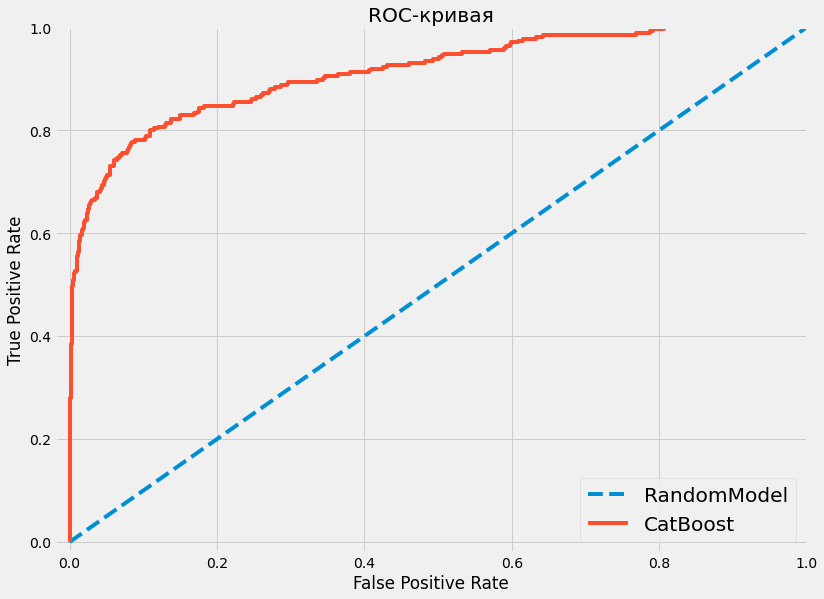

In [126]:
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)

plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


plt.xlim([-0.02,1])
plt.ylim([-0.02,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(fpr, tpr, label='CatBoost')
plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

In [127]:
cat_gscv.best_estimator_.get_feature_importance(prettified=True)
# phik_overview['Exited'].sort_values(ascending=False)

,Feature Id,Importances
0,period,40.281776
1,MonthlyCharges,10.960618
2,TotalCharges,9.839367
3,Type,7.623884
4,PaymentMethod,6.254166
5,Partner,3.280611
6,cl_cat,2.813386
7,MultipleLines,2.356358
8,PaperlessBilling,1.960081
9,OnlineBackup,1.706518


In [128]:
importances_df = pd.DataFrame(cat_gscv.best_estimator_.feature_importances_, index = X_test.columns, columns=['importances'])
importances_df = importances_df.sort_values(by='importances', ascending=False)
importances_df

,importances
period,40.281776
MonthlyCharges,10.960618
TotalCharges,9.839367
Type,7.623884
PaymentMethod,6.254166
Partner,3.280611
cl_cat,2.813386
MultipleLines,2.356358
PaperlessBilling,1.960081
OnlineBackup,1.706518


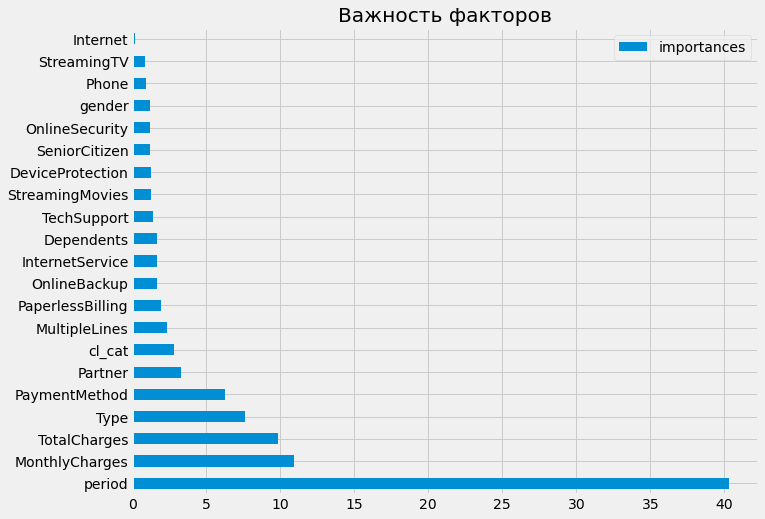

In [129]:
importances_df.plot(kind='barh', figsize=(10, 8), title='Важность факторов')
plt.show()

**Shap**

In [130]:
! pip install shap

In [131]:
import shap
shap.initjs()

In [132]:
explainer = shap.TreeExplainer(cat_gscv.best_estimator_)
shap_values = explainer.shap_values(test[X])

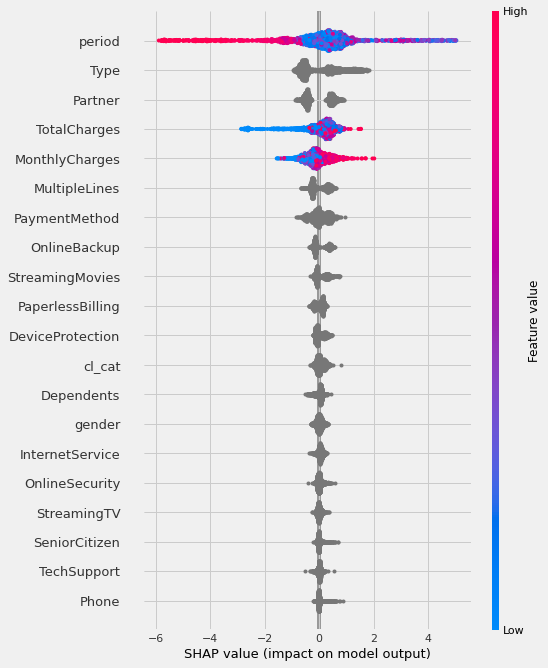

In [133]:
shap.summary_plot(shap_values, test[X])

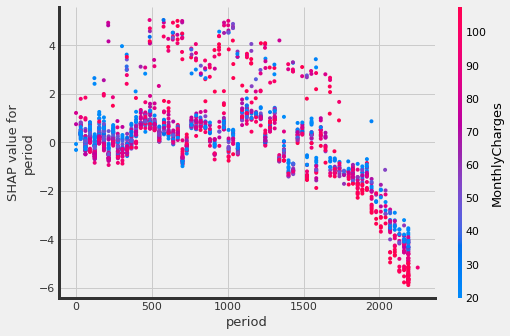

In [134]:
shap.dependence_plot("period", shap_values, test[X])

**Дополнительное задание**

In [135]:
# test['y_score_no_cross_val'] = model.predict_proba(test_data)[:,1]

In [136]:
# probabilities_valid = cat_search.best_estimator_.predict_proba(X_test)
# probabilities_one_test = probabilities_valid[:, 1]

# roc_auc = roc_auc_score(y_test, probabilities_one_test)
# roc_auc

# cat_search.best_estimator_.predict_proba(X_test)

In [137]:
test['score_catboost'] = cat_gscv.best_estimator_.predict_proba(X_test)[:,1]

In [138]:
test

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,period,gender,SeniorCitizen,Partner,Dependents,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Internet,MultipleLines,Phone,cl_cat,target,score_catboost
customerID,,,,,,,,,,,,,,,,,,,,,
4827-DPADN,Two year,Yes,Bank transfer (automatic),83.30,3831.80,1399,Female,0,Yes,Yes,...,Yes,Yes,Yes,Yes,1,Yes,1,3,1,0.885115
3746-EUBYR,Month-to-month,Yes,Bank transfer (automatic),74.60,155.17,62,Male,0,Yes,No,...,No,No,No,No,1,Yes,1,1,0,0.033486
5976-JCJRH,Month-to-month,Yes,Electronic check,70.30,843.60,365,Male,0,Yes,No,...,No,No,No,No,1,No,1,1,0,0.040148
5186-PEIZU,Month-to-month,No,Bank transfer (automatic),19.25,673.75,1067,Female,0,No,No,...,No,No,No,No,No,No,1,2,0,0.001670
0867-MKZVY,Month-to-month,No,Electronic check,82.40,1933.10,702,Female,0,Yes,No,...,No,No,No,No,1,Yes,1,2,0,0.024403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7750-EYXWZ,One year,No,Electronic check,60.65,727.80,365,Female,0,No,No,...,Yes,Yes,Yes,Yes,1,No,No,1,0,0.070169
5022-KVDQT,Month-to-month,Yes,Electronic check,81.30,2370.71,822,Male,0,No,No,...,Yes,No,No,No,1,Yes,1,2,0,0.053639
3777-XROBG,Two year,No,Credit card (automatic),19.55,881.71,1249,Female,0,Yes,Yes,...,No,No,No,No,No,No,1,3,1,0.788468


<AxesSubplot:>

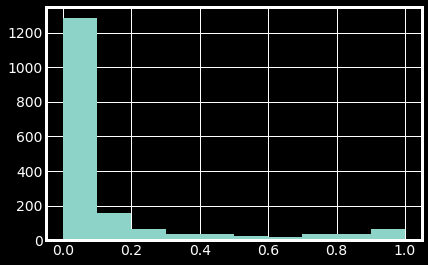

In [139]:
plt.style.use('dark_background')
test['score_catboost'].hist()

In [140]:
test['y_pred'] = (test['score_catboost'] > 0.5) * 1

In [141]:
test['y_pred'].mean()

0.10221465076660988

In [142]:
confusion_matrix(test[y],test['y_pred'])

array([[1466,   20],
       [ 115,  160]])

In [143]:
tn, fp, fn, tp = confusion_matrix(test[y],test['y_pred']).ravel()

In [144]:
tn, fp, fn, tp

(1466, 20, 115, 160)

In [145]:
test['y_pred_new'] = (test['score_catboost'] > 0.4) * 1

In [146]:
f1_score(test[y],test['y_pred'])

0.7032967032967034

In [147]:
f1_score(test[y],test['y_pred_new'])

0.7261663286004056

In [148]:
len(test['score_catboost'])

1761

In [149]:
test['score_catboost'].nunique()

1755

In [150]:
thrs = [0] + list(test['score_catboost'].unique())

In [151]:
from tqdm.notebook import tqdm

In [152]:
result = []
for thr in tqdm(thrs):
    test['y_pred_new'] = (test['score_catboost'] > thr) * 1
    result.append((thr, f1_score(test[y],test['y_pred_new'])))

  0%|          | 0/1756 [00:00<?, ?it/s]

In [153]:
t = pd.DataFrame(result,columns=['thr','f1'])

In [154]:

t.sort_values('f1',ascending=False)


,thr,f1
1572,0.393354,0.728745
1204,0.381840,0.728370
526,0.385977,0.727273
758,0.376312,0.726908
789,0.370582,0.726547
...,...,...
1405,0.997742,0.028674
1318,0.998085,0.021583
1427,0.999030,0.014440
213,0.999054,0.007246


In [155]:
t[t['f1'] == t['f1'].max()]

,thr,f1
1572,0.393354,0.728745


In [156]:
test['y_pred_new'] = (test['score_catboost'] > 0.49978) * 1

In [157]:
confusion_matrix(test[y],test['y_pred_new'])

array([[1466,   20],
       [ 115,  160]])

In [158]:
from sklearn.metrics import accuracy_score
accuracy_score(test[y],test['y_pred'])

0.9233390119250426

In [159]:
accuracy_score(test[y],test['y_pred_new'])

0.9233390119250426

In [160]:
from sklearn.metrics import classification_report

In [161]:
print(classification_report(test[y],test['y_pred']))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1486
           1       0.89      0.58      0.70       275

    accuracy                           0.92      1761
   macro avg       0.91      0.78      0.83      1761
weighted avg       0.92      0.92      0.92      1761



In [162]:
print(classification_report(test[y],test['y_pred_new']))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1486
           1       0.89      0.58      0.70       275

    accuracy                           0.92      1761
   macro avg       0.91      0.78      0.83      1761
weighted avg       0.92      0.92      0.92      1761



In [163]:
result1 = []
for thr in tqdm(thrs):
    test['y_pred_new'] = (test['score_catboost'] > thr) * 1
    result.append((thr, accuracy_score(test[y],test['y_pred_new'])))

  0%|          | 0/1756 [00:00<?, ?it/s]

In [164]:
t1 = pd.DataFrame(result1,columns=['thr','accur'])
t1

,thr,accur


In [165]:
t1.sort_values('accur',ascending=False)

,thr,accur


In [166]:
t1[t1['accur'] == t1['accur'].max()]

,thr,accur


## Общий вывод по результатам исследования

В рамках проекта было проведено исследование поведения клиентов оператора связи «Ниединогоразрыва.ком». 


На первом этапе были загружены данные, сделан их предварительный анализ.
Сделан исследовательский анализ данных (EDA).  Сделана визуализация влияния признаков с использованием пакета phik.

Были построены модели машинного обучения и подобранны гиперпараметры.
Были обучены 4 модели:

 - LogisticRegression,
 - RandomForestClassifier
 - CatBoostClassifier
 - LGBM

 - Лучший результат показала модель CatBoostClassifier со значением ROC-AUC на тестовой выборке 0.91, что выше, чем требуемое значение.

 - Самые важные факторы - сколько клиент пользуется услугами и сколько он платит в месяц

# Отчет по итогам проекта

Описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.
Исследование в рамках проекта было проведено в соответствии с первоначально составленным планом, в котором были предусмотрены все необходимые шаги, чтобы добиться основной цели проекта.

Первоначальный план проекта:

1. Загрузить данные, сделать их предварительный анализ: рассмотреть и проанализировать каждый набор данных, посмотреть взаимосвязи.
2. Провести предобработку данных, объединить данные, подготовить признаки и, при необходимости, добавить новые признаки. Выделить/создать целевой признак. Сделать исследовательский анализ данных (EDA) и выводы по результатам EDA.
3. Разделить итоговый датасет на тренировочную и тестовую выборки. В случае необходимости, провести кодирование и масштабирование.
4. Определить модели, подходящие для исследования (предварительно предполагается использовать Классификаторы LogisticRegression, CatBoost, LightGBM и одну из ассемблинговых моделей - RandomForest), провести подбор гиперпараметров, выделить важные фичи.
5. Сравнить модели по результатам кросс-валидации и оценить эффективность лучшей модели на тестовой выборке.
6. Провести анализ влияния различных факторов лучшей модели.
7. Общий вывод по результатам исследования.

Все пункты первоначального плана проекта были выполнены, новых глобальных задач не появилось.

В ходе роботы над проектом был сделано:
 - Установлены или обновлены необходимые пакеты Jupyter, которые отсутствовали в тренажере.
 -  Импортированы библиотеки, которые использовались для анализа.
 - Загружены первоначальные данные.
 - Произведен предварительный анализ данных, что дало понимание, каким образом их необходимо подготовить для машинного обучения. В рамках анализа, дынные были проверены на отсутствие пропусков, дубликаты, а также проанализированы их типы.

- В рамках предобработки данных были добавлены дополнительные признаки, а также изменили типы данных у уже имеющихся. Осуществлена сборка всех датасетов в один большой, заполнены образовавшиеся пропуски.

    •	Добавили категориальный признак «target», показывающий уход клиента от компании.

    •	Преобразовали типы данных у признаков BeginDate и EndDate (на datetime), MonthlyCharges, TotalCharges (на float), а также заменены пропущенные значения.

    •	Предварительно в столбце 'EndDate' значения 'No' были заменены на текущую дату - '2020-02-01', а пропуски в столбце 'TotalCharges' - на '0'.

    •	Добавлен признак 'period' - количество дней, в течение которых клиент пользовался услугами компании

    •	На основании вышеуказанного признака, создали также категорийный признак 'cl_cat', состоящий из 3 категорий.

    •	В датасеты Internet и Phone были добавим признаки, показывающие пользуются ли клиенты этими услугами. Это сделано для объединения в один датасет, чтобы не потерять информативность при объединении

    •	объединения таблиц в один большой датасет было сделано с помощью функции «merge» по Индексам, т.к. поле id клиента было занесено как Индекс в каждом датасете при импортировании данных

    •	При создании одного большего датасета, образовались пропуски так как в 2х датасетах отсутствуют некоторое количество клиентов. Пропуски были заменены на «No».

В дальнейшем, также пришлось поменять тип параметра «SeniorCitizen» с Int на String. Это было сделано, т.к. этот параметр был отнесен в разряд категориальных переменных, а CatBoost принимает в качестве таких переменных только данные , которые не имеют формат Integer.

Исследовательских анализ данных, в котором были детально рассмотрены особенности полученного дата сета, показал:
 -	Выявлен дисбаланс классов результирующего признака.
 -	Показано, что в основном ушедшие клиенты были те, у которых ежемесячный платеж был от 70 до 110.
 -	Также наблюдается нулевая корреляция между результирующим признаком и использованием услуг телефони, т.е. аказчик в первую очередь выступает, телефонным оператором, а уже потом как интернет провайдер.
 - Используя пакет Phik, рассмотрели какие параметры оказывают наибольшее влияние на конечный результат. Сделана визуализация влияния признаков.
 - Была выявлена мультиколлениарность между рядом признаков: target, EndDate, period и BeginDate. Это весьма логично, т.к. мы построили признаки target и period на основании BeginDate и EndDate. Чтобы избежать проблемы переобучения, при подготовке датасета для машинного обучения, BeginDate и EndDate необходимо будет удалить.

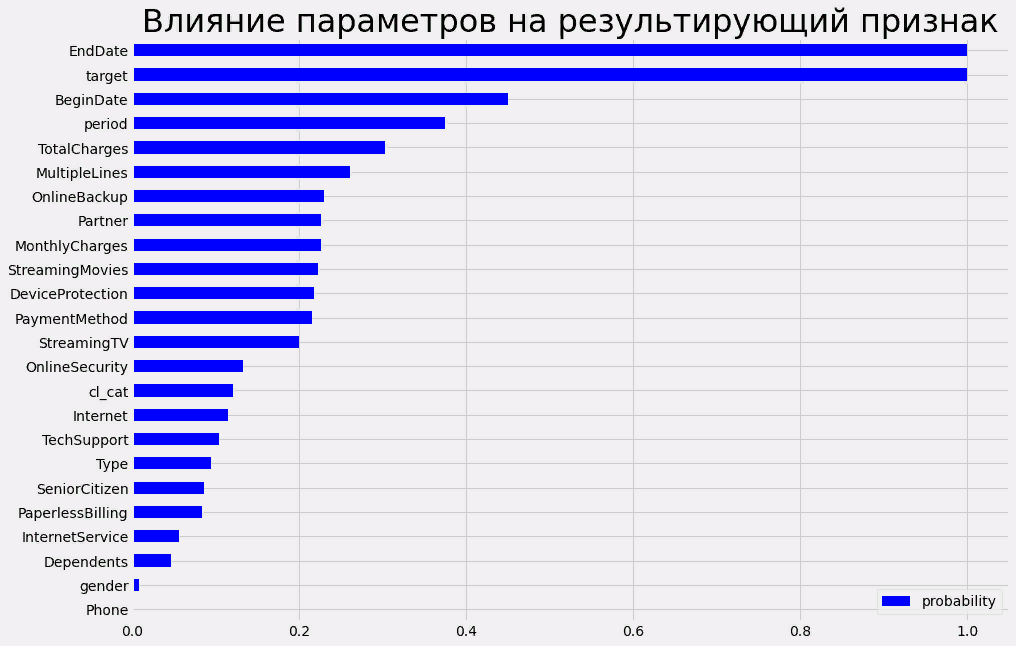



Подготовка данных для машинного обучения.
С учетом того, что в рамках проекта мы планировали использовать разные модели машинного обучения, было подготовлено 2 набора данных. Один набор данных был закодирован и масштабирован, а другой оставлен в первозданном виде, т.к. в Бустинговых моделях эти функции являются встроенными в пакет.

Изначально, с помощью функции test_train_ split датасет был разбит на тестовую (25%) и тренировочную выборки. Чтобы избежать перекоса в данных, при разбиении была использована стратификация.

После разбиения, для одного набора данных было сделано кодирование категориальных признаков методом прямого кодирования OHE и масштабирование числовых признаков методом стандартизации при помощи StandardScaler для того, чтобы числовые признаки привести к одной размерности.


Борьба с дисбалансом классов методами upsample, downsample не проводилась. Была использована балансировка классов внутри модели;

Перед обучением были удалены признаки BeginDate, EndDate. 

Обучение моделей: 
В рамках выполнения данного проекта были обучены 4 модели: 
 - LogisticRegression,
 - RandomForestClassifier
 - CatBoostClassifier
 - LGBM

Было проведено обучение моделей и их проверка на кросс-валидации, а затем была выбрана лучшая по результатам на трейнинговой выборке.
В результате обучения лучше все себя показала модель CatBosstClassifier, на ней была достигнута метрика ROC_AUC = 0.91

Таблица с результатами обучения на :

                        ROC-AUC
 - LogisticRegression  - 0.793918
 - RandomForest       -  0.820824
 - CatBoostClassifier -  0.911588
 - LGBM	              -  0.879023

Гиперпараметры лучшей модели CatBoost:
 - 'depth' - 4
 - 'l2_leaf_reg' - 1
 - 'learning_rat' - 0.1
 
 
 Random State  = 30723 (дата начала финальног проекта)

В дальнейшем продолжено тестирование модели CatBoostClassifier.
В итоге была обучена модель CatBoostClassifier и на тесте была достигнута метрика ROC-AUC равная 0,91. 

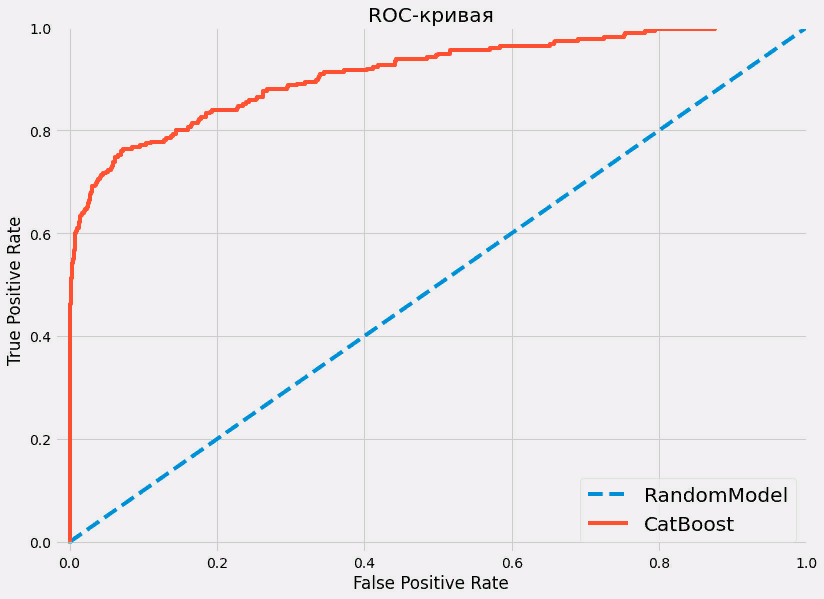 


Была визуализирована важность признаков.
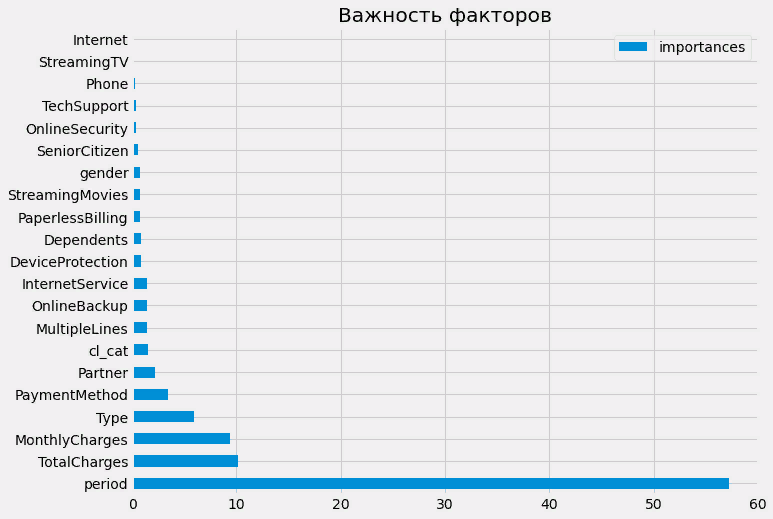
 

Какие трудности возникли и как вы их преодолели?
Особых трудностей, в ходе выполнения работы не было.
